# Double Pendulum Trajectory Forecasting using RNN 
Omkar Thawakar , SGGSIE&T Nanded

In [11]:
#What are we working with?
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [12]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import random


In [13]:
#TF Version
tf.__version__



'1.4.1'

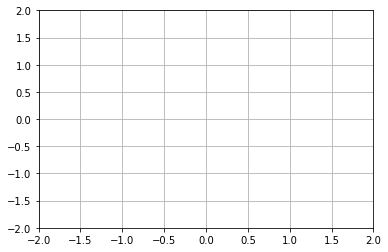

In [14]:

# for each experiment value of l1,l2,m1,m2 and th1,th2,w1,w2 are same so explicitely add these features after training.

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.1
t = np.arange(0.0, 100, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)

th1 = 120.0
w1 = 0.0
th2 = 0.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

#print("x1 : ",x1)
#print("y1 : ",y1)

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

#print("x2 : ",x2)
#print("y2 : ",y2)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),interval=25, blit=True, init_func=init)



#### Generate some data

length of test data :  1000
(1000, 1)
length of test data :  912
(912, 1)


/Users/omkarchakradharthawakar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


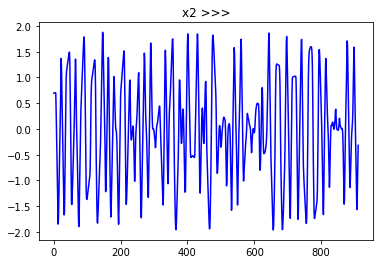

In [15]:
random.seed(111)
#ts.head(10)

f = open("data/x2.txt" , "r")
t = open("data/time_slots.txt" , "r")
array1 = []
array2 = []

for line in f.read().split('\n') :
  array1.append(line )
for line in t.read().split('\n') :
  array2.append(line )
f.close()
t.close()
array1.pop()
array2.pop()
data = []

for i in range(len(array1)):
    data.append([array1[i]])
test = np.array(data)
mylist = test.astype(np.float)

print("length of test data : ",len(mylist))
print(mylist.shape)
mylist.reshape(1,-1)
#print(mylist)

ts = np.delete(mylist,[i for i in range(912,1001)],0)

print("length of test data : ",len(ts))
print(ts.shape)
ts.reshape(1,-1)
#print(ts)

plt.plot(ts,c='b')
plt.title('x2 >>>')
plt.show()


#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [16]:
TS = np.array(ts)
num_periods = 100
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
#print(len(x_data))
#print("x_data : ",x_data)
x_batches = x_data.reshape(-1, 100, 1)

#print (len(x_batches))
print ("x_batches shape : ",x_batches.shape)
#print (x_batches[0:1])

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
#print(y_data.shape)
y_batches = y_data.reshape(-1, 100, 1)


#print ("y_batches : ",y_batches[0:1])
print ("y_batches shape : ",y_batches.shape)

x_batches shape :  (9, 100, 1)
y_batches shape :  (9, 100, 1)


#### Pull out our test data

In [17]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 100, 1)
    testY = TS[-(num_periods):].reshape(-1, 100, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print(len(X_test))
#print (X_test)

print (Y_test.shape)
print(len(Y_test))
#print (Y_test)

(1, 100, 1)
1
(1, 100, 1)
1


In [18]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

print(X)


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #advanced gradient descent method 
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

Tensor("Placeholder:0", shape=(?, 100, 1), dtype=float32)


In [19]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("outputs_x", sess.graph)
    print(sess.run(init))
    writer.close()

None


In [20]:
epochs = 5000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
errors = []
iterations = []
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        errors.append(loss.eval(feed_dict={X: x_batches, y: y_batches}))
        iterations.append(ep)
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)  
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)
    

0 	MSE: 581.299
100 	MSE: 21.9139
200 	MSE: 12.3388
300 	MSE: 8.77889
400 	MSE: 6.77277
500 	MSE: 5.22588
600 	MSE: 4.9033
700 	MSE: 6.821
800 	MSE: 3.76563
900 	MSE: 2.98707
1000 	MSE: 2.75795
1100 	MSE: 2.17701
1200 	MSE: 2.0295
1300 	MSE: 2.43033
1400 	MSE: 1.79029
1500 	MSE: 1.72781
1600 	MSE: 5.30996
1700 	MSE: 1.79617
1800 	MSE: 1.8805
1900 	MSE: 1.38517
2000 	MSE: 1.40465
2100 	MSE: 2.30666
2200 	MSE: 1.20538
2300 	MSE: 1.23577
2400 	MSE: 1.09588
2500 	MSE: 2.44423
2600 	MSE: 1.0314
2700 	MSE: 1.11898
2800 	MSE: 0.887401
2900 	MSE: 1.05396
3000 	MSE: 0.764037
3100 	MSE: 6.89383
3200 	MSE: 3.06152
3300 	MSE: 2.16557
3400 	MSE: 1.60913
3500 	MSE: 1.23409
3600 	MSE: 0.987386
3700 	MSE: 0.823753
3800 	MSE: 0.730782
3900 	MSE: 0.579324
4000 	MSE: 0.554329
4100 	MSE: 0.529518
4200 	MSE: 0.442478
4300 	MSE: 0.409039
4400 	MSE: 0.400824
4500 	MSE: 0.356394
4600 	MSE: 0.336441
4700 	MSE: 0.333451
4800 	MSE: 0.338818
4900 	MSE: 0.289973
[[[  1.14109322e-01]
  [  8.96275520e-01]
  [  1.448

In [21]:
for i in range(len(y_pred[0])):
    print(Y_test[0][i] , y_pred[0][i])

[ 0.65130467] [ 0.11410932]
[ 1.09132992] [ 0.89627552]
[ 1.37144135] [ 1.44897664]
[ 1.21651892] [ 1.71158433]
[ 0.97162507] [ 0.8172189]
[ 0.72589668] [ 0.46351272]
[ 0.48853033] [ 0.40691406]
[ 0.27832533] [ 0.38316971]
[ 0.11489424] [-0.00178191]
[-0.02420258] [-0.22794408]
[-0.21427559] [-0.26626092]
[-0.50669374] [-0.30810457]
[-0.85925168] [-0.73403341]
[-1.13167657] [-1.59167254]
[-0.95782469] [-1.36332059]
[-0.61549438] [-0.28320479]
[-0.30240578] [ 0.21157284]
[-0.05761067] [-0.14463066]
[ 0.06338403] [-0.32162577]
[ 0.07530041] [-0.12596682]
[ 0.06631454] [ 0.16767716]
[ 0.0894524] [ 0.29701078]
[ 0.12633476] [ 0.0917605]
[ 0.13430522] [ 0.20406596]
[ 0.09856873] [ 0.30929607]
[ 0.03986353] [-0.15431131]
[-0.00484348] [-0.25821829]
[-0.00530485] [-0.296938]
[ 0.03851473] [ 0.32963818]
[ 0.10526395] [ 0.20661542]
[ 0.19581869] [ 0.08956158]
[ 0.35444059] [ 0.19669402]
[ 0.38391367] [ 0.4662289]
[ 0.24240832] [ 0.24906678]
[ 0.09770974] [-0.07866869]
[ 0.01087227] [ 0.147808]


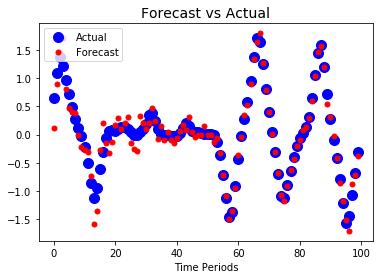

In [22]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()



0.896276
0.537195347766
100
[0.82479885735421021, 0.17873091660864704, 0.056535617569429084, 0.40695249758644347, 0.15891538085358409, 0.36146185976063561, 0.16706490159623735, 0.37669723502933816, 1.0155091389574211, 8.4181721225944077, 0.24260970361966022, 0.39193135693594194, 0.1457294509909573, 0.40647299499562695, 0.42335084896025166, 0.53987427925879139, 1.6996322698932671, 1.5104837776229436, 6.0742396569336385, 2.672856912107068, 1.5285130009544887, 2.3203219634295973, 0.27367180022630683, 0.51941940363727945, 2.1378719806526667, 4.870990104676693, 52.312515634560341, 54.974767971748527, 7.5587561854505019, 0.96283173561152857, 0.54263007557194132, 0.445057866894704, 0.21441077185500015, 0.027467981031326232, 1.8051264163052774, 12.594957531741299, 5.3571735449221132, 4.2819539565130231, 4.5964089273276816, 4.592308004455262, 1.7052968854886312, 1.4625166417764086, 0.42771118969625821, 0.57828031735837893, 1.0957301414730016, 0.38351893693781069, 2.0905982344459582, 1.257396412

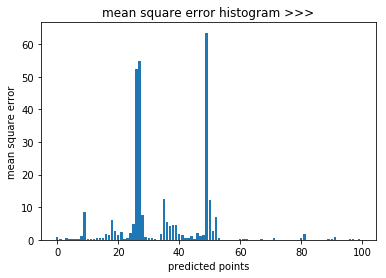

In [23]:
error = []
print(y_pred[0][1][0])
print(abs(y_pred[0][0][0]-Y_test[0][0][0]))
print(len(y_pred[0]))
for i in range(len(y_pred[0])):
    err = abs((y_pred[0][i][0]-Y_test[0][i][0])/Y_test[0][i][0])
    error.append(err)
x = np.arange(len(error))
print(error)
plt.bar(x,error,align='center')
plt.xlabel('predicted points')
plt.ylabel('mean square error')
plt.title('mean square error histogram >>>')
plt.show()

(5000,)


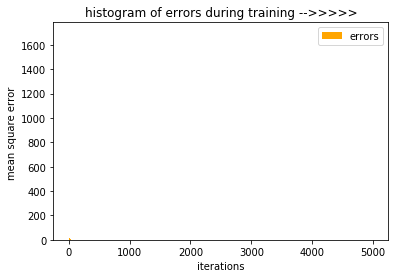

In [24]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

errors=np.array(errors)
iterations=np.array(iterations)
print(errors.shape)
#print(errors)

plt.hist(errors,iterations,label='errors', facecolor='orange')

plt.xlabel('iterations')
plt.ylabel('mean square error ')
plt.title('histogram of errors during training -->>>>>')
plt.legend()
plt.show()

(5000,)


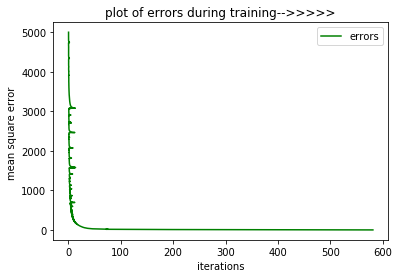

In [25]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

errors=np.array(errors)
iterations=np.array(iterations)
print(errors.shape)
#print(errors)

plt.plot(errors,iterations,label='errors',color='green')

plt.xlabel('iterations')
plt.ylabel('mean square error ')
plt.title('plot of errors during training-->>>>>')
plt.legend()
plt.show()